This file analyze the results for regression.

In [203]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from pathlib import Path
from pprint import pprint
from scipy.io import loadmat
from tqdm import trange, tqdm
from scipy.stats import ttest_ind
from collections import defaultdict as ddict
from easydict import EasyDict as edict

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [204]:
# import my own functions
import sys
sys.path.append("../../mypkg")
import importlib

# paras
import paras
importlib.reload(paras);
from paras import paras

# some useful constants
import constants
importlib.reload(constants)
from constants import REGION_NAMES, REGION_NAMES_WLOBE, RES_ROOT, DATA_ROOT

In [205]:
# utils
import utils.matrix
importlib.reload(utils.matrix)
from utils.matrix import eig_sorted

import utils.misc
importlib.reload(utils.misc)
from utils.misc import paras2name, cumsum_cutoff, save_pkl_dict2folder, load_pkl_folder2dict

import utils.projection
importlib.reload(utils.projection)
from utils.projection import euclidean_proj_l1ball

import utils.standardize
importlib.reload(utils.standardize)
from utils.standardize import minmax, minmax_mat, minmax_pn

import utils.brain_plot
importlib.reload(utils.brain_plot)
from utils.brain_plot import reorder_U, U_2brain_vec

In [206]:
# gtvdn
import gtvdn.gtvdn_post
importlib.reload(gtvdn.gtvdn_post)
from gtvdn.gtvdn_post import est_singular_vals, update_kp

## Parameters

In [207]:
pprint(paras)

{'Cs': array([1.0e+02, 2.5e+01, 1.0e+01, 5.0e+00, 2.0e+00, 1.0e+00, 5.0e-01,
       2.0e-01, 1.0e-01, 5.0e-02, 1.0e-02]),
 'L': 100.0,
 'Lmin': 200,
 'T': 2,
 'cur_dir': PosixPath('/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg'),
 'cutoff': 0.6,
 'data_dir': PosixPath('../data'),
 'decimate_rate': 5,
 'downsample_rate': 20,
 'fct': 0.5,
 'fig_dir': PosixPath('../figs'),
 'is_detrend': True,
 'kappa': 3.21,
 'kps': array([1.        , 1.003003  , 1.00600601, 1.00900901, 1.01201201,
       1.01501502, 1.01801802, 1.02102102, 1.02402402, 1.02702703,
       1.03003003, 1.03303303, 1.03603604, 1.03903904, 1.04204204,
       1.04504505, 1.04804805, 1.05105105, 1.05405405, 1.05705706,
       1.06006006, 1.06306306, 1.06606607, 1.06906907, 1.07207207,
       1.07507508, 1.07807808, 1.08108108, 1.08408408, 1.08708709,
       1.09009009, 1.09309309, 1.0960961 , 1.0990991 , 1.1021021 ,
       1.10510511, 1.10810811, 1.11111111, 1.11411411, 1.11711712,
       1.12012012

In [208]:
# this parameters only for this file
_paras = edict()
_paras.folder_name = "method3"

## Load results

In [209]:
# load results
cur_res = load_pkl_folder2dict(RES_ROOT/_paras.folder_name)

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/can_pts_ctrls.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/can_pts_ADs.pkl
Load file /data/rajlab1/user_data/jin/

In [210]:
pprint(cur_res.keys())

dict_keys(['dXXmats_AD', 'dXXmats_ctrl', 'Amats_AD', 'Amats_ctrl', 'CPDresult_ctrl', 'CPDresult_AD', 'can_pts_ctrls', 'can_pts_ADs', 'cpts_ctrls', 'cpts_ADs', 'ndXmats_ctrl', 'ndXmats_AD', 'nXmats_ctrl', 'nXmats_AD', 'post_paras', 'singular_vals_ADs', 'cpts_ADs_selected', 'dwells_ADs_selected', 'rank_ADs', 'singular_vals_ctrls', 'cpts_ctrls_selected', 'dwells_ctrls_selected', 'rank_ctrls'])


In [123]:
# save the weights and U
# AD
all_sigs = np.concatenate(cur_res.singular_vals_ADs, axis=1)
all_dwells = np.concatenate(cur_res.dwells_ADs_selected).reshape(1, -1)
all_sub_idxs = np.concatenate([[ix+1]*len(cur_res.dwells_ADs_selected[ix]) for ix in range(88)]).reshape(1, -1)
all_data = np.concatenate([all_sub_idxs, all_dwells, all_sigs], axis=0).T
all_data = pd.DataFrame(all_data, columns=["Sub_id", "dwell"]+[f"sing_{ix+1}" for ix in range(20)])
all_data.to_csv(RES_ROOT/_paras.folder_name/"AD_singular_method3.csv", index=False)

# ctrl
all_sigs = np.concatenate(cur_res.singular_vals_ctrls, axis=1)
all_dwells = np.concatenate(cur_res.dwells_ctrls_selected).reshape(1, -1)
all_sub_idxs = np.concatenate([[ix+1]*len(cur_res.dwells_ctrls_selected[ix]) for ix in range(88)]).reshape(1, -1)
all_data = np.concatenate([all_sub_idxs, all_dwells, all_sigs], axis=0).T
all_data = pd.DataFrame(all_data, columns=["Sub_id", "dwell"]+[f"sing_{ix+1}" for ix in range(20)])
all_data.to_csv(RES_ROOT/_paras.folder_name/"ctrl_singular_method3.csv", index=False)

np.savetxt(RES_ROOT/_paras.folder_name/"U_method3.csv", cur_res.CPDresult_ctrl[0])
np.savetxt(RES_ROOT/_paras.folder_name/"V_method3.csv", cur_res.CPDresult_ctrl[1])

## get the dataset

In [211]:
ncpts_ADs_selected = [len(cpts) for cpts in cur_res.cpts_ADs_selected]
ncpts_ctrls_selected = [len(cpts) for cpts in cur_res.cpts_ctrls_selected]

In [310]:
cur_cutoff = cur_res.post_paras.rank_curoff
cur_cutoff = 1.2
# selected U and calculate weighted U (ABS wU)
wUs_abs_AD = []
wUs_abs_mean_AD = []
wUs_abs_max_AD = []
ws_abs_mean_AD = []
ws_abs_max_AD = []
for ix in range(len(cur_res.singular_vals_ADs)):
    cur_singular_val_abs = np.abs(cur_res.singular_vals_ADs[ix])
    cur_raw_B3row = np.abs(cur_res.CPDresult_AD[-1][ix, :])
    cur_keep_idx = cumsum_cutoff(cur_raw_B3row, cur_cutoff)
    #cur_keep_idx = minmax(cur_raw_B3row) > cur_cutoff
    cur_dwells = cur_res.dwells_ADs_selected[ix]
    
    cur_ws_abs = cur_singular_val_abs[cur_keep_idx, :]
    cur_Us_abs = np.array(cur_res.CPDresult_ctrl[0][:, cur_keep_idx])
    
    cur_wUs_abs = np.matmul(cur_Us_abs, cur_ws_abs)
    cur_wUs_abs_mean = cur_wUs_abs.mean(axis=1)
    
    wUs_abs_AD.append(cur_wUs_abs)
    wUs_abs_max_AD.append(cur_wUs_abs[:, np.argmax(cur_dwells)])
    wUs_abs_mean_AD.append(cur_wUs_abs_mean)
    ws_abs_mean_AD.append(cur_ws_abs[:, :].mean())
    ws_abs_max_AD.append(cur_ws_abs[:, :].max())
    
wUs_abs_ctrl = []
wUs_abs_mean_ctrl = []
wUs_abs_max_ctrl = []
ws_abs_mean_ctrl = []
ws_abs_max_ctrl = []
for ix in range(len(cur_res.singular_vals_ctrls)):
    cur_singular_val_abs = np.abs(cur_res.singular_vals_ctrls[ix])
    cur_raw_B3row = np.abs(cur_res.CPDresult_ctrl[-1][ix, :])
    cur_keep_idx = cumsum_cutoff(cur_raw_B3row, cur_cutoff)
    #cur_keep_idx = minmax(cur_raw_B3row) > cur_cutoff
    cur_dwells = cur_res.dwells_ctrls_selected[ix]
    
    cur_ws_abs = cur_singular_val_abs[cur_keep_idx, :]
    cur_Us_abs = np.array(cur_res.CPDresult_ctrl[0][:, cur_keep_idx])
    
    cur_wUs_abs = np.matmul(cur_Us_abs, cur_ws_abs)
    cur_wUs_abs_mean = cur_wUs_abs.mean(axis=1)
    
    wUs_abs_ctrl.append(cur_wUs_abs)
    wUs_abs_max_ctrl.append(cur_wUs_abs[:, np.argmax(cur_dwells)])
    wUs_abs_mean_ctrl.append(cur_wUs_abs_mean)
    ws_abs_mean_ctrl.append(cur_ws_abs[:, :].mean())
    ws_abs_max_ctrl.append(cur_ws_abs[:, :].max())
    
wUs_abs_mean_AD = np.array(wUs_abs_mean_AD)
wUs_abs_mean_ctrl = np.array(wUs_abs_mean_ctrl)
wUs_abs_max_AD = np.array(wUs_abs_max_AD)
wUs_abs_max_ctrl = np.array(wUs_abs_max_ctrl)

## Regression 

In [335]:
import numbers
# return the predicted probs for each test obs
def clf_2probs(clf, X_test):
    probs = clf.predict_proba(X_test)
    return probs[:, clf.classes_==1].reshape(-1)

def LOO_pred_givenC(cur_X, cur_Y, Cs=1, is_prg=True):
    probs = []
    if is_prg:
        prog_bar = trange(len(cur_Y))
    else:
        prog_bar = range(len(cur_Y))
    if isinstance(Cs, numbers.Number):
        Cs = np.ones_like(cur_Y)*Cs
    for ix in prog_bar:
        cur_X_test = cur_X[ix, :].reshape(1, -1)
        cur_Y_test = cur_Y[ix].reshape(1, -1)
        cur_X_train = np.delete(cur_X, ix, axis=0)
        cur_Y_train = np.delete(cur_Y, ix)
        clf = LogisticRegression(random_state=0, C=Cs[ix], penalty=paras.penalty, solver="liblinear").fit(cur_X_train, cur_Y_train)
        #clf = RandomForestClassifier(random_state=0).fit(cur_X_train, cur_Y_train)
        #clf = DecisionTreeClassifier(random_state=0).fit(cur_X_train, cur_Y_train)
        probs.append(clf_2probs(clf, cur_X_test))
    return np.array(probs).reshape(-1)

In [336]:
def LOO_bestC(cur_X, cur_Y, Cs, is_prg=0, is_C_only=1):
    Cs = np.array(Cs)
    cur_aucs = []
    if is_prg:
        prog_bar = tqdm(Cs)
    else:
        prog_bar = Cs
    for cur_C in prog_bar: 
        cur_pred_probs = LOO_pred_givenC(cur_X, cur_Y, Cs=cur_C, is_prg=0)
        cur_auc = roc_auc_score(cur_Y, cur_pred_probs)
        cur_aucs.append(cur_auc)
        cur_best_C = Cs[np.argmax(cur_aucs)]
    cur_best_C = Cs[np.argmax(cur_aucs)]
    if is_C_only:
        return cur_best_C
    else:
        return cur_best_C, cur_aucs

In [337]:
def tmp_foldwU(mat):
    assert mat.shape[-1] == 68
    mat_half = (mat[:, :34] + mat[:, 34:])/2
    return mat_half

In [415]:
# prepare for Y and X
reg_Y = np.concatenate([np.ones_like(cur_res.rank_ADs), np.zeros_like(cur_res.rank_ctrls)])
reg_X_B3 = np.concatenate([
                minmax_mat(np.abs(cur_res.CPDresult_AD[2]), is_row=True),
                minmax_mat(np.abs(cur_res.CPDresult_ctrl[2]), is_row=True)
            ], axis=0)
reg_X_wU_abs_mean = np.concatenate([wUs_abs_mean_AD, wUs_abs_mean_ctrl], axis=0)
reg_X_wU_abs_max = np.concatenate([wUs_abs_max_AD, wUs_abs_max_ctrl], axis=0)
reg_X_rank = np.concatenate([cur_res.rank_ADs, cur_res.rank_ctrls])
reg_X_ncpts = np.concatenate([ncpts_ADs_selected, ncpts_ctrls_selected])
reg_X_ws_max = np.concatenate([ws_abs_max_AD, ws_abs_max_ctrl])
reg_X_ws_mean = np.concatenate([ws_abs_mean_AD, ws_abs_mean_ctrl])


reg_X = np.concatenate([
                        reg_X_wU_abs_max, # try minmax each row
                        reg_X_rank.reshape(-1, 1), 
                        reg_X_ncpts.reshape(-1, 1), 
                        #reg_X_ws_max.reshape(-1, 1)
                       ], axis=1)
#reg_X = reg_X_wU_abs_max
reg_X_std = (reg_X - reg_X.mean(axis=0))/reg_X.std(axis=0)

### AUC under LOO

In [416]:
Cs = paras.Cs[:11]
paras.Cs = np.concatenate([Cs, [5e-3, 1e-3]])
paras.penalty = "l2"

In [417]:
gopt_C = LOO_bestC(reg_X_std, reg_Y, paras.Cs, 1)
print(gopt_C, paras.Cs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]

0.01 [1.0e+02 2.5e+01 1.0e+01 5.0e+00 2.0e+00 1.0e+00 5.0e-01 2.0e-01 1.0e-01
 5.0e-02 1.0e-02 5.0e-03 1.0e-03]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 869.62it/s]


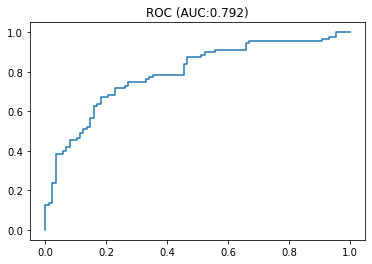

In [418]:
pred_probs = LOO_pred_givenC(reg_X_std, reg_Y, Cs=gopt_C, is_prg=1)
fpr, tpr, thresholds = roc_curve(reg_Y, pred_probs, pos_label=1)
auc = roc_auc_score(reg_Y, pred_probs)

plt.title(f"ROC (AUC:{auc:.3f})")
plt.plot(fpr, tpr)

### CV for tuning C for each Obs

In [33]:
import multiprocessing as mp
def run_fn(ix):
    cur_X_test = reg_X_std[ix, :].reshape(1, -1)
    cur_Y_test = reg_Y[ix].reshape(1, -1)
    cur_X_train = np.delete(reg_X_std, ix, axis=0)
    cur_Y_train = np.delete(reg_Y, ix)
    
    print(f"Start {ix}")
    cur_best_C =  LOO_bestC(cur_X_train, cur_Y_train, paras.Cs, 0)
    print(f"Finished {ix}")
    return (ix, cur_best_C)


if __name__ == "__main__":
    with mp.Pool(processes=20) as pool:
        res_proc = []
        for ix in range(len(reg_Y)):
            res_proc.append( pool.apply_async(run_fn, [ix,]) )
        res = [cur_proc.get() for cur_proc in res_proc] # to retrieve the results
    pool.join()

6014
25783

9101615

1112
1317


14

18
19
22


2425



In [34]:
res = sorted(res, key=lambda x:x[0])
best_Cs = [re[-1] for re in res]

probs = []
pred_probs = LOO_pred_givenC(reg_X_std, reg_Y, Cs=best_Cs, is_prg=1)
fpr, tpr, thresholds = roc_curve(reg_Y, pred_probs, pos_label=1)
auc = roc_auc_score(reg_Y, pred_probs)

plt.title(f"ROC (AUC:{auc:.3f})")
plt.plot(fpr, tpr)

### AUC under 10000 CV

In [419]:
# AUC under repetitions
np.random.seed(0)
nobs = reg_X_std.shape[0]
rep_aucs = []
for j in tqdm(range(10000)):
    test_idxs = np.random.choice(nobs, int(nobs/5), False)
    train_idxs = np.delete(np.arange(nobs), test_idxs)
    clf = LogisticRegression(penalty=paras.penalty, random_state=0, C=gopt_C, solver="liblinear")
    clf.fit(reg_X_std[train_idxs], reg_Y[train_idxs])
    cur_eprobs = clf_2probs(clf, reg_X_std[test_idxs, :])
    cur_auc = roc_auc_score(reg_Y[test_idxs], cur_eprobs)
    rep_aucs.append(cur_auc)
mean_auc = np.mean(rep_aucs)
std_auc = np.std(rep_aucs)
print(f"The mean of AUC under 1000 repetitions is {mean_auc:.3f} and the standard deviation is {std_auc:.3f}, "
      f"the 95% CI is ({np.quantile(rep_aucs, 0.025):.3f}, {np.quantile(rep_aucs, 0.975):.3f}).")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 678.11it/s]

The mean of AUC under 1000 repetitions is 0.790 and the standard deviation is 0.070, the 95% CI is (0.641, 0.917).


### final fit  and bootstrap analysis

In [420]:
final_clf = LogisticRegression(random_state=0, C=gopt_C, 
                               penalty=paras.penalty, 
                               solver="liblinear").fit(reg_X_std, reg_Y)
final_coefs = final_clf.coef_.reshape(-1)

In [421]:
# bootstrap CIs
np.random.seed(1)
rep_num = 10000
parass_boot = []
for _ in trange(rep_num):
    boot_idx = np.random.choice(len(reg_Y), len(reg_Y))
    cur_Y_boot = reg_Y[boot_idx]
    cur_X_boot = reg_X_std[boot_idx]
    cur_clf = LogisticRegression(penalty=paras.penalty, random_state=0, C=gopt_C, solver="liblinear")
    cur_clf.fit(cur_X_boot, cur_Y_boot)
    paras_boot = cur_clf.coef_.reshape(-1)
    parass_boot.append(paras_boot)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1080.50it/s]


In [422]:
parass_boot = np.array(parass_boot)
# 95% CIs
lows, ups = final_coefs-parass_boot.std(axis=0)*1.96, final_coefs+parass_boot.std(axis=0)*1.96
keep_idx_boot = np.bitwise_or(lows >0,  ups < 0)
keep_idx_id_boot =  np.where(keep_idx_boot)[0]

# Pvalue
test_stat_boot = final_coefs/parass_boot.std(axis=0)
norm_rv = scipy.stats.norm()
## to be consistent, I think we should use two-sided pvalue
boot_pvs = 2*(1-norm_rv.cdf(np.abs(test_stat_boot)))

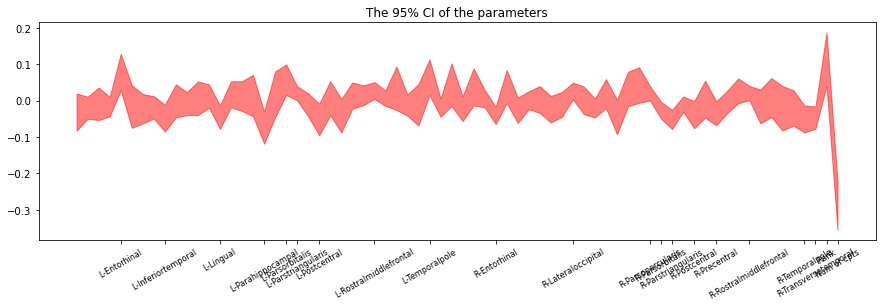

In [423]:
xlabs = np.concatenate([REGION_NAMES, ["Rank", "Num of cpts"]])
#xlabs = np.concatenate([REGION_NAMES[:], ["Rank", "Num of cpts", "Lambda"]])
plt.figure(figsize=[15, 4])
plt.fill_between(list(range(len(lows))), lows, ups, color="red", alpha=.5)
plt.title("The 95% CI of the parameters")
_ = plt.xticks(keep_idx_id_boot, xlabs[keep_idx_id_boot], rotation=30, fontsize=8)

In [424]:
# Bootstrap p value and CI are consistent
tmp_idx = np.bitwise_xor(boot_pvs <= 0.05, keep_idx_boot)
res_tb = {
   "Feature" : xlabs[tmp_idx],  
    "Parameters": final_coefs[tmp_idx],
    "Lower": lows[tmp_idx],
    "Upper": ups[tmp_idx],
    "Pvalues": boot_pvs[tmp_idx]
}
pd.set_option("display.precision", 3)
res_tb = pd.DataFrame(res_tb)
print(res_tb)

Empty DataFrame
Columns: [Feature, Parameters, Lower, Upper, Pvalues]
Index: []


In [425]:
#  output table
res_tb = {
   "Feature" : xlabs[keep_idx_boot],  
    "Parameters": final_coefs[keep_idx_boot],
    "Lower": lows[keep_idx_boot],
    "Upper": ups[keep_idx_boot],
    "Pvalues": boot_pvs[keep_idx_boot]
}
#pd.set_option("display.precision", 3)
pd.set_option('display.float_format',lambda x : '%.4f' % x)
res_tb = pd.DataFrame(res_tb)
print(res_tb)

                   Feature  Parameters   Lower   Upper  Pvalues
0             L-Entorhinal      0.0787  0.0285  0.1288   0.0021
1       L-Inferiortemporal     -0.0480 -0.0850 -0.0111   0.0108
2                L-Lingual     -0.0455 -0.0778 -0.0133   0.0056
3        L-Parahippocampal     -0.0744 -0.1184 -0.0303   0.0009
4          L-Parsorbitalis      0.0578  0.0158  0.0997   0.0070
5       L-Parstriangularis      0.0200  0.0007  0.0394   0.0425
6            L-Postcentral     -0.0519 -0.0955 -0.0084   0.0194
7   L-Rostralmiddlefrontal      0.0280  0.0048  0.0512   0.0180
8           L-Temporalpole      0.0647  0.0159  0.1134   0.0093
9             R-Entorhinal     -0.0406 -0.0644 -0.0168   0.0008
10      R-Lateraloccipital      0.0266  0.0036  0.0497   0.0236
11       R-Parsopercularis      0.0201  0.0003  0.0399   0.0463
12         R-Parsorbitalis     -0.0266 -0.0497 -0.0036   0.0236
13      R-Parstriangularis     -0.0518 -0.0781 -0.0256   0.0001
14           R-Postcentral     -0.0386 -

In [429]:
# final parameter, no abs, remove pv <0.05
mm_pn_paras = minmax(np.abs(final_coefs[:68]))
nlog_pvs = -np.log10(boot_pvs[:68])
mm_pn_paras[nlog_pvs < -np.log10(0.05)] = 0
out_paras = U_2brain_vec(reorder_U(mm_pn_paras))
print(np.sum(mm_pn_paras ==0), np.sum(nlog_pvs < -np.log10(0.05)))
np.savetxt(RES_ROOT/f"./{_paras.folder_name}/abs_paras.txt", out_paras)
#pd.DataFrame({"Name": REGION_NAMES, 
#              "Vec": mm_pn_paras}).to_csv(RES_ROOT/f"./{_paras.folder_name}/abs_paras.csv", 
#                                          index=False)

49 49


In [430]:
mm_pn_paras

array([0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.60744039, 0.        ,
       0.        , 0.        , 0.        , 0.57530176, 0.        ,
       0.        , 0.        , 0.94515299, 0.        , 0.73207119,
       0.24854508, 0.        , 0.65712877, 0.        , 0.        ,
       0.        , 0.        , 0.35023561, 0.        , 0.        ,
       0.        , 0.        , 0.82037562, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.51221095, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.33303278, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.24969407, 0.33303278, 0.65583496,
       0.        , 0.48602358, 0.        , 0.43985822, 0.        ,
       0.        , 0.2623595 , 0.        , 0.        , 0.        ,
       0.        , 0.63823651, 0.58891208])

In [373]:
keep_idx_boot =  final_coefs!=0
keep_idx_id_boot =  np.where(keep_idx_boot)[0]

#  output table
res_tb = {
   "Feature" : xlabs[keep_idx_boot],  
    "Parameters": final_coefs[keep_idx_boot],
}
#pd.set_option("display.precision", 3)
pd.set_option('display.float_format',lambda x : '%.4f' % x)
res_tb = pd.DataFrame(res_tb)
print(res_tb)

              Feature  Parameters
0        L-Entorhinal      0.0453
1           L-Lingual     -0.1140
2   L-Parahippocampal     -0.2302
3   L-Parsopercularis      0.0102
4     L-Parsorbitalis      0.2272
5       L-Postcentral     -0.2296
6      L-Temporalpole      0.0933
7          R-Bankssts      0.0038
8    R-Middletemporal     -0.0379
9                Rank      0.2834
10        Num of cpts     -1.0532


In [374]:
# final parameter, no abs, remove pv <0.05
mm_pn_paras = minmax(np.abs(final_coefs[:68]))
out_paras = U_2brain_vec(reorder_U(mm_pn_paras))
np.savetxt(RES_ROOT/f"./{_paras.folder_name}/abs_lasso_paras.txt", out_paras)
#pd.DataFrame({"Name": REGION_NAMES, 
#              "Vec": mm_pn_paras}).to_csv(RES_ROOT/f"./{_paras.folder_name}/abs_paras.csv", 
#                                          index=False)

In [376]:
mm_pn_paras[34:]

array([0.01662778, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16458265, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])